In [233]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## 데이터 로딩

In [234]:
train = pd.read_csv('train.csv').drop(columns = 'transaction_id') 
apt_data = train[train['city'] == '서울특별시'] # 지역을 서울로만 한정
apt_data = apt_data.drop(columns = ['apartment_id', 'city', 'dong', 'jibun', 'apt', 'addr_kr'], axis = 1) # 범주형 삭제
oil_price = pd.read_csv('국제_원유가격20080101_20171131.csv', encoding='cp949')
price_change = pd.read_csv('price_change.csv', encoding='UTF-8')

## 아파트 가격데이터 datetime 통일

In [235]:
train

,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.8200,2002,200801,21~31,2,37500
1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.1700,1973,200801,1~10,6,20000
2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.7400,2007,200801,1~10,6,38500
3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.3900,2003,200801,11~20,15,118000
4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.4300,2004,200801,21~31,3,120000
...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,22000
1216549,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,30750
1216550,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,29500
1216551,9586,부산광역시,정관읍 용수리,1364,정관신도시롯데캐슬,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,26700


In [236]:
date_avg = []
for i in apt_data['transaction_date']:# 날짜가 다 1~10, 11~20, 21~30 과 같은 형태로 되어있어 평균값으로 통일
    if i == '11~20':
        date_avg.append('15')
    elif i == '1~10':
        date_avg.append('05')
    else:
        date_avg.append('25')
        
apt_data['date_avg'] = date_avg      

In [237]:
apt_data['transaction_date'] = apt_data['transaction_year_month'].astype('str') + apt_data['date_avg'] # 년도+월 로 이루어진 컬럼과 위에서만든 컬럼 합치기

In [238]:
apt_data = apt_data.drop(columns = ['transaction_year_month', 'date_avg']) # 통일해서 이제 필요없어서 제거

In [239]:
apt_data["transaction_date"] = pd.to_datetime(apt_data["transaction_date"]) 

In [240]:
apt_data # exclusive_use_area => 전용면적

,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price
0,84.82,2002,2008-01-25,2,37500
1,99.17,1973,2008-01-05,6,20000
2,84.74,2007,2008-01-05,6,38500
3,146.39,2003,2008-01-15,15,118000
4,194.43,2004,2008-01-25,3,120000
...,...,...,...,...,...
1184014,59.72,2011,2017-11-15,9,53000
1184015,59.87,2009,2017-11-25,12,53000
1184016,84.74,2009,2017-11-25,3,56500
1184017,84.74,2009,2017-11-25,9,55500


In [241]:
apt_data = apt_data.groupby('transaction_date').mean().reset_index()  # 같은 날짜별로 전부 합치기

In [242]:
apt_data

,transaction_date,exclusive_use_area,year_of_completion,floor,transaction_real_price
0,2008-01-05,71.319094,1996.689845,8.548013,35815.171082
1,2008-01-15,70.938502,1996.284384,8.435616,34882.781918
2,2008-01-25,71.455052,1996.341876,8.334554,34834.696110
3,2008-02-05,72.265355,1996.507937,8.457672,35922.383598
4,2008-02-15,70.855270,1996.320755,8.381350,34485.933962
...,...,...,...,...,...
352,2017-10-15,80.284361,1998.635348,9.646937,66627.877070
353,2017-10-25,80.571541,1999.406327,9.896309,67519.816520
354,2017-11-05,82.509710,1998.979130,9.646980,72752.877442
355,2017-11-15,81.441121,1999.022250,9.569015,75141.608982


## 금리 데이터프레임 만들기

In [243]:
data = [
    ["2017-11-30", 1.50],
    ["2016-06-09", 1.25],
    ["2015-06-11", 1.50],
    ["2015-03-12", 1.75],
    ["2014-10-15", 2.00],
    ["2014-08-14", 2.25],
    ["2013-05-09", 2.50],
    ["2012-10-11", 2.75],
    ["2012-07-12", 3.00],
    ["2011-06-10", 3.25],
    ["2011-03-10", 3.00],
    ["2011-01-13", 2.75],
    ["2010-11-16", 2.50],
    ["2010-07-09", 2.25],
    ["2009-02-12", 2.00],
    ["2009-01-09", 2.50],
    ["2008-12-11", 3.00],
    ["2008-11-07", 4.00],
    ["2008-10-27", 4.25],
    ["2008-10-09", 5.00],
    ["2008-08-07", 5.25],
    ["2007-08-09", 5.00]
] # 한국은행 기준금리 추이

interest_rate = pd.DataFrame(data, columns=["Date", "Value"])
#interest_rate["Date"] = pd.to_datetime(interest_rate["Date"])

In [244]:
interest_rate

,Date,Value
0,2017-11-30,1.50
1,2016-06-09,1.25
2,2015-06-11,1.50
3,2015-03-12,1.75
4,2014-10-15,2.00
5,2014-08-14,2.25
6,2013-05-09,2.50
7,2012-10-11,2.75
8,2012-07-12,3.00
9,2011-06-10,3.25


In [245]:
day_avg = []
for i in interest_rate['Date']:
    if 10 >= int(i[-2:]) >= 1:
        day_avg.append(i[:-2] + '05')
    elif 20>= int(i[-2:]) > 10:
        day_avg.append(i[:-2] + '15')
    else:
        day_avg.append(i[:-2] + '25')

In [246]:
interest_rate['Date'] = day_avg 
interest_rate["Date"] = pd.to_datetime(interest_rate["Date"])

In [247]:
interest_rate['Value'].nunique()

13

## 유가 데이터 datetime 통일

In [248]:
day_avg_2 = []
for i in oil_price['기간']:
    if 10 >= int(i[-3:-1]) >= 1:
        day_avg_2.append(i[:-3] + '05일')
    elif 20>= int(i[-3:-1]) > 10:
        day_avg_2.append(i[:-3] + '15일')
    else:
        day_avg_2.append(i[:-3] + '25일')
        
        
oil_price['기간'] = day_avg_2

In [249]:
converted_date = []
date_format = "%y년%m월%d일"

for i in oil_price['기간']:
    converted_date.append(pd.to_datetime(i, format=date_format))
    
oil_price['기간'] = converted_date

In [250]:
oil_price = oil_price.groupby('기간').mean().reset_index()

## 물가 datetime 통일

In [252]:
price_change

,date,total_price_index,living_price_index,Fresh_Food_Index
0,2008-01-01,0.5,0.5,-1.0
1,2008-02-01,0.4,0.3,1.3
2,2008-03-01,0.9,1.3,-4.5
3,2008-04-01,0.6,0.7,-0.5
4,2008-05-01,0.8,1.0,-2.1
...,...,...,...,...
115,2017-08-01,0.6,0.8,11.3
116,2017-09-01,0.1,0.4,3.3
117,2017-10-01,-0.1,-0.4,-8.4
118,2017-11-01,-0.7,-0.8,-8.0


In [253]:
price_avg = []
for i in price_change['date']:
    price_avg.append(i[:-2] + '05')
    
price_change['date'] = price_avg

In [254]:
# 'date' 열이 날짜 형식이 아닌 경우 변환
price_change['date'] = pd.to_datetime(price_change['date'], errors='coerce')

In [255]:
price_change

,date,total_price_index,living_price_index,Fresh_Food_Index
0,2008-01-05,0.5,0.5,-1.0
1,2008-02-05,0.4,0.3,1.3
2,2008-03-05,0.9,1.3,-4.5
3,2008-04-05,0.6,0.7,-0.5
4,2008-05-05,0.8,1.0,-2.1
...,...,...,...,...
115,2017-08-05,0.6,0.8,11.3
116,2017-09-05,0.1,0.4,3.3
117,2017-10-05,-0.1,-0.4,-8.4
118,2017-11-05,-0.7,-0.8,-8.0


# 데이터 합치기

### apt_data + interest_rate

In [256]:
merged_df = pd.merge(apt_data, interest_rate, how='left', left_on='transaction_date', right_on='Date')

In [257]:
merged_df['Value'] = merged_df['Value'].fillna(method='ffill') # 이전 금리로 결측값 채우기

In [258]:
merged_df['Value'] = merged_df['Value'].fillna(5.0)

In [259]:
merged_df = merged_df.drop(columns=['Date'])

In [260]:
merged_df

,transaction_date,exclusive_use_area,year_of_completion,floor,transaction_real_price,Value
0,2008-01-05,71.319094,1996.689845,8.548013,35815.171082,5.00
1,2008-01-15,70.938502,1996.284384,8.435616,34882.781918,5.00
2,2008-01-25,71.455052,1996.341876,8.334554,34834.696110,5.00
3,2008-02-05,72.265355,1996.507937,8.457672,35922.383598,5.00
4,2008-02-15,70.855270,1996.320755,8.381350,34485.933962,5.00
...,...,...,...,...,...,...
352,2017-10-15,80.284361,1998.635348,9.646937,66627.877070,1.25
353,2017-10-25,80.571541,1999.406327,9.896309,67519.816520,1.25
354,2017-11-05,82.509710,1998.979130,9.646980,72752.877442,1.25
355,2017-11-15,81.441121,1999.022250,9.569015,75141.608982,1.25


## +oil_price

In [261]:
oil_price = oil_price.groupby('기간').mean().reset_index()

In [262]:
data = pd.merge(merged_df, oil_price, how='left', left_on='transaction_date', right_on='기간')

In [263]:
data = data.drop(columns = '기간')

## +price_change

In [264]:
data = pd.merge(data, price_change, how='left', left_on='transaction_date', right_on='date')

In [265]:
# 이전 물가로 결측값 채우기
data['total_price_index'] = data['total_price_index'].fillna(method='ffill') 
data['living_price_index'] = data['living_price_index'].fillna(method='ffill')
data['Fresh_Food_Index'] = data['Fresh_Food_Index'].fillna(method='ffill') 

In [266]:
data.columns

Index(['transaction_date', 'exclusive_use_area', 'year_of_completion', 'floor',
       'transaction_real_price', 'Value', 'Dubai', 'Brent', 'WTI', 'date',
       'total_price_index', 'living_price_index', 'Fresh_Food_Index'],
      dtype='object')

# 완성~!

In [267]:
data = data[['transaction_date', 'exclusive_use_area', 'Value', 'Dubai', 'Brent', 'WTI', 'total_price_index', 'living_price_index', 'Fresh_Food_Index', 'transaction_real_price']]

In [268]:
data

,transaction_date,exclusive_use_area,Value,Dubai,Brent,WTI,total_price_index,living_price_index,Fresh_Food_Index,transaction_real_price
0,2008-01-05,71.319094,5.00,90.668571,95.535714,96.787143,0.5,0.5,-1.0,35815.171082
1,2008-01-15,70.938502,5.00,86.401667,90.450000,91.721667,0.5,0.5,-1.0,34882.781918
2,2008-01-25,71.455052,5.00,85.121111,90.074444,90.458750,0.5,0.5,-1.0,34834.696110
3,2008-02-05,72.265355,5.00,85.577500,89.493333,89.068333,0.4,0.3,1.3,35922.383598
4,2008-02-15,70.855270,5.00,89.928750,95.165000,95.907143,0.4,0.3,1.3,34485.933962
...,...,...,...,...,...,...,...,...,...,...
352,2017-10-15,80.284361,1.25,55.442857,57.398750,51.487500,-0.1,-0.4,-8.4,66627.877070
353,2017-10-25,80.571541,1.25,56.741429,59.450000,53.088571,-0.1,-0.4,-8.4,67519.816520
354,2017-11-05,82.509710,1.25,60.695000,62.760000,56.218750,-0.7,-0.8,-8.0,72752.877442
355,2017-11-15,81.441121,1.25,60.591667,62.256667,55.928333,-0.7,-0.8,-8.0,75141.608982


# 시각화

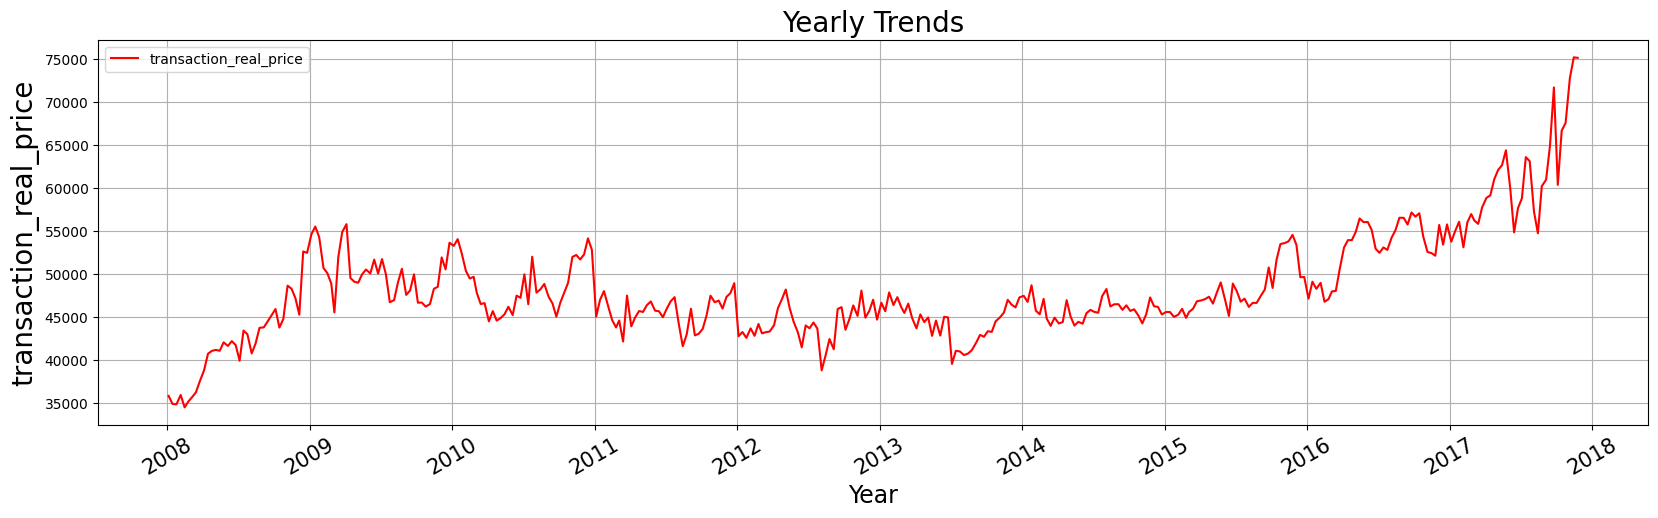

In [269]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transaction_date', y='transaction_real_price', data=data, label='transaction_real_price', color = 'Red')


plt.title('Yearly Trends',fontsize=20)
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('transaction_real_price',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

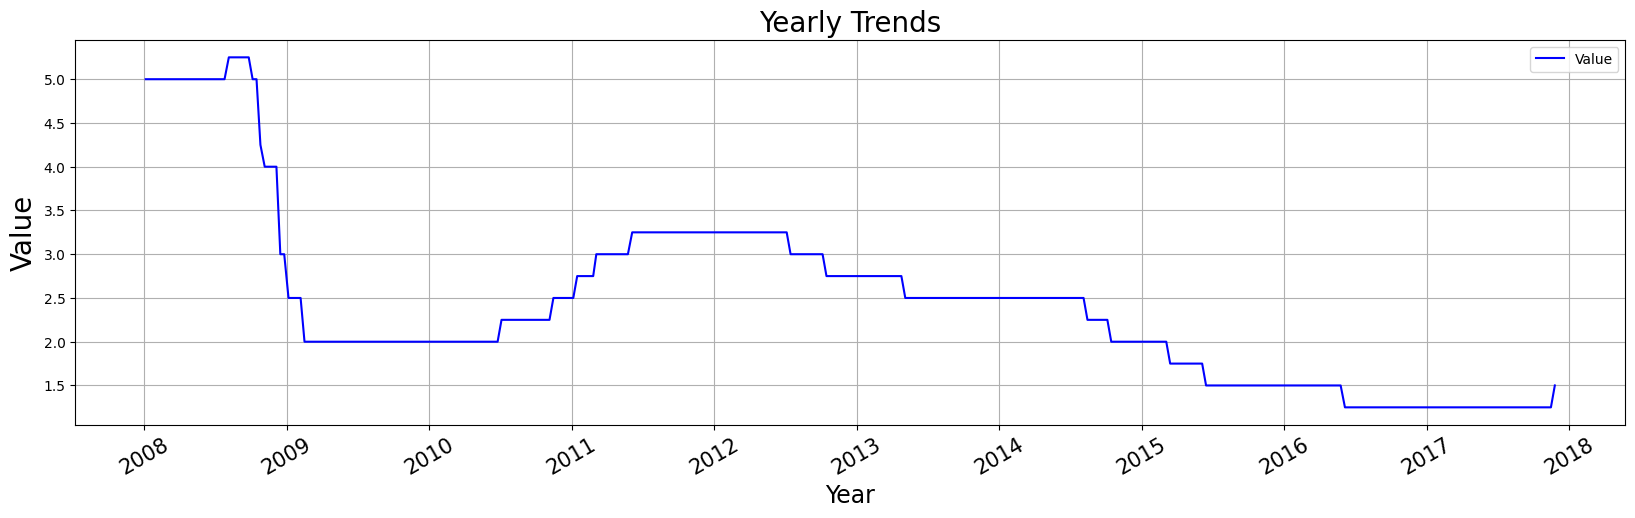

In [270]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transaction_date', y='Value', data=data, label='Value', color = 'Blue')


plt.title('Yearly Trends',fontsize=20)
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Value',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

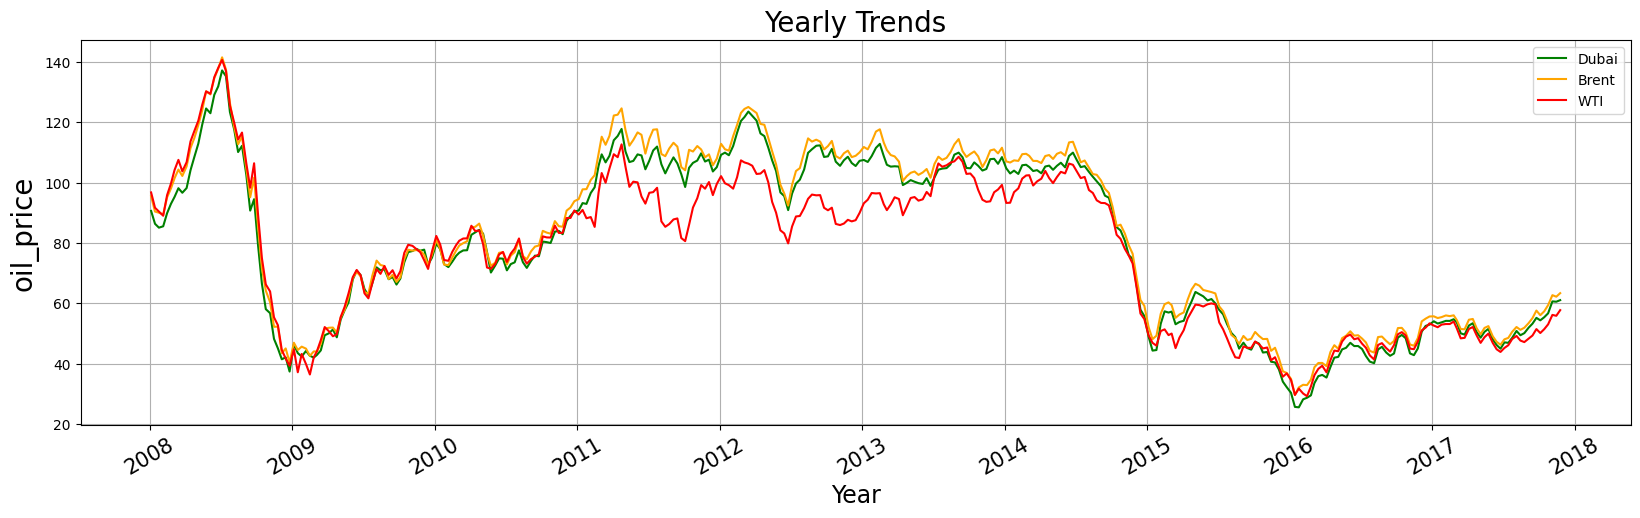

In [271]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transaction_date', y='Dubai', data=data, label='Dubai', color = 'Green')
sns.lineplot(x='transaction_date', y='Brent', data=data, label='Brent', color = 'Orange')
sns.lineplot(x='transaction_date', y='WTI', data=data, label='WTI', color = 'Red')


plt.title('Yearly Trends',fontsize=20)
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('oil_price',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

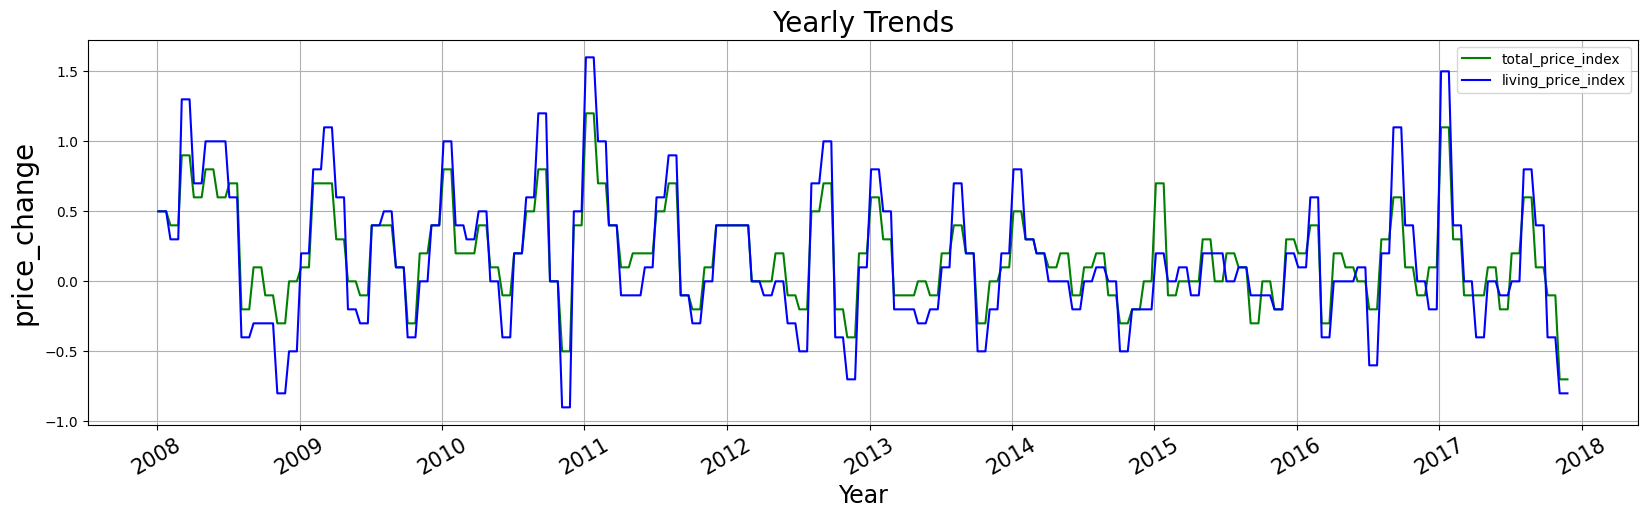

In [272]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transaction_date', y='total_price_index', data=data, label='total_price_index', color = 'Green')
sns.lineplot(x='transaction_date', y='living_price_index', data=data, label='living_price_index', color = 'Blue')
#sns.lineplot(x='transaction_date', y='Fresh_Food_Index', data=data, label='Fresh_Food_Index', color = 'Red')


plt.title('Yearly Trends',fontsize=20)
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('price_change',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

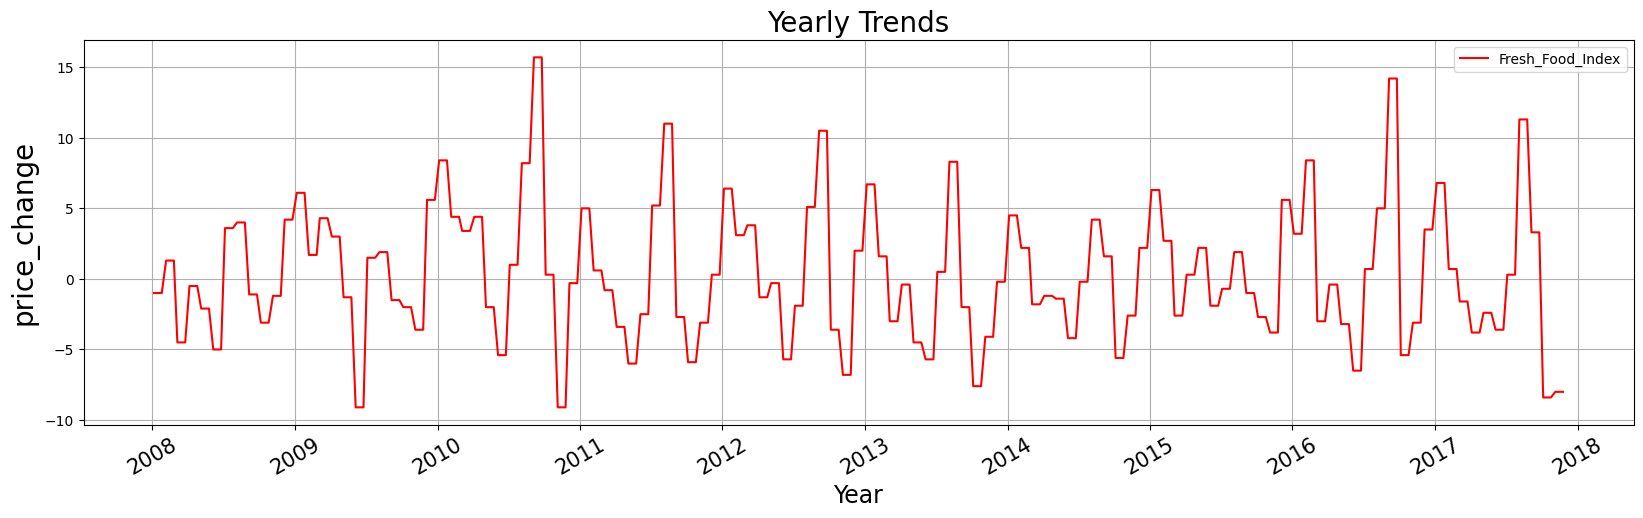

In [273]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transaction_date', y='Fresh_Food_Index', data=data, label='Fresh_Food_Index', color = 'Red')


plt.title('Yearly Trends',fontsize=20)
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('price_change',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [274]:
correlation= data.corr()['transaction_real_price']

C:\Users\A\AppData\Local\Temp\ipykernel_19276\1260278947.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation= data.corr()['transaction_real_price']


In [275]:
correlation

exclusive_use_area        0.699930
Value                    -0.676913
Dubai                    -0.612413
Brent                    -0.622418
WTI                      -0.638457
total_price_index        -0.213252
living_price_index       -0.144268
Fresh_Food_Index         -0.044443
transaction_real_price    1.000000
Name: transaction_real_price, dtype: float64

# 시계열

In [276]:
data

,transaction_date,exclusive_use_area,Value,Dubai,Brent,WTI,total_price_index,living_price_index,Fresh_Food_Index,transaction_real_price
0,2008-01-05,71.319094,5.00,90.668571,95.535714,96.787143,0.5,0.5,-1.0,35815.171082
1,2008-01-15,70.938502,5.00,86.401667,90.450000,91.721667,0.5,0.5,-1.0,34882.781918
2,2008-01-25,71.455052,5.00,85.121111,90.074444,90.458750,0.5,0.5,-1.0,34834.696110
3,2008-02-05,72.265355,5.00,85.577500,89.493333,89.068333,0.4,0.3,1.3,35922.383598
4,2008-02-15,70.855270,5.00,89.928750,95.165000,95.907143,0.4,0.3,1.3,34485.933962
...,...,...,...,...,...,...,...,...,...,...
352,2017-10-15,80.284361,1.25,55.442857,57.398750,51.487500,-0.1,-0.4,-8.4,66627.877070
353,2017-10-25,80.571541,1.25,56.741429,59.450000,53.088571,-0.1,-0.4,-8.4,67519.816520
354,2017-11-05,82.509710,1.25,60.695000,62.760000,56.218750,-0.7,-0.8,-8.0,72752.877442
355,2017-11-15,81.441121,1.25,60.591667,62.256667,55.928333,-0.7,-0.8,-8.0,75141.608982


# 집값과 금리 시계열 분해

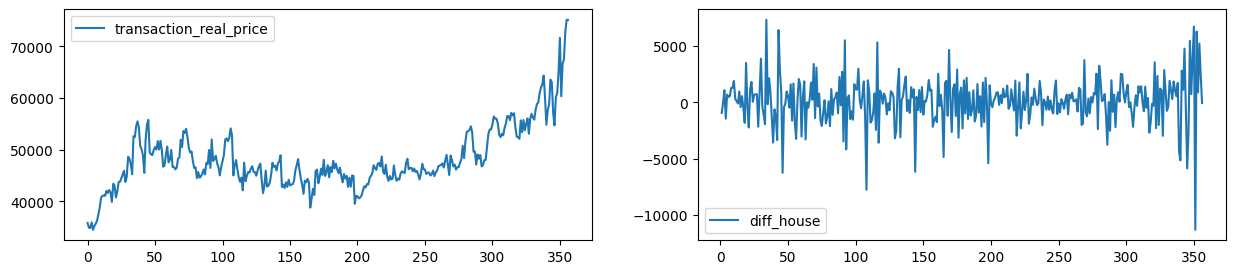

In [277]:
data['diff_house'] = data.transaction_real_price.diff(periods = 1)

fig, axes = plt.subplots(1,2, figsize=(15,3))
data.plot(y='transaction_real_price', ax=axes[0])
data.plot(y='diff_house', ax=axes[1])
plt.show()

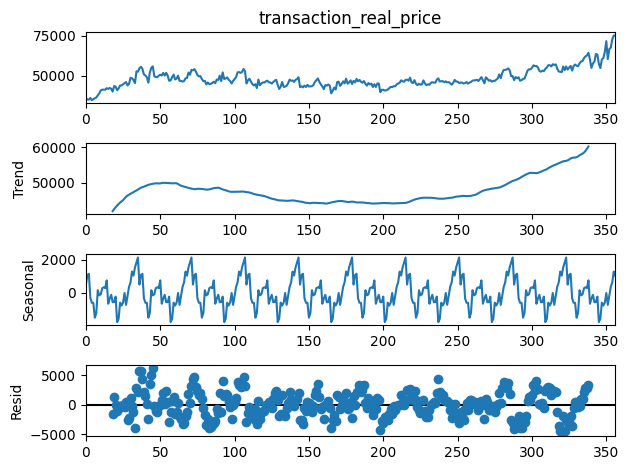

In [278]:
result1 = seasonal_decompose(data.transaction_real_price, model='additive', 
                            period=36)
result1.plot()
plt.show()

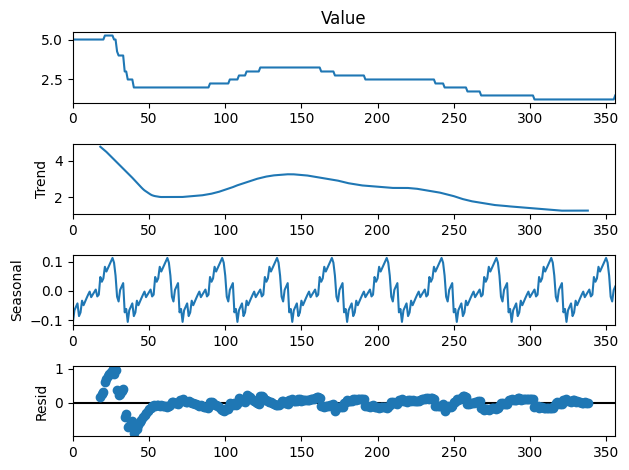

In [279]:
result2 = seasonal_decompose(data.Value, model='additive', 
                            period=36)
result2.plot()
plt.show()

<AxesSubplot: >

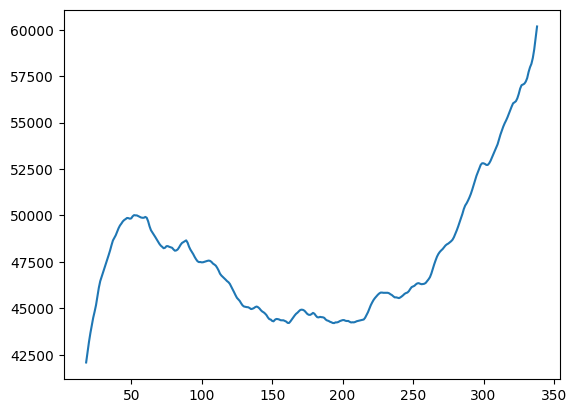

In [280]:
result1.trend.plot()

<AxesSubplot: >

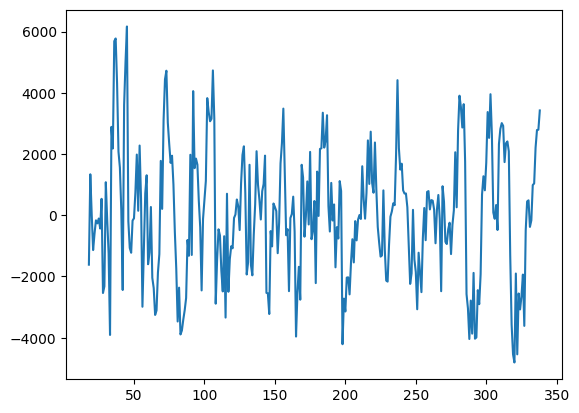

In [281]:
result1.resid.plot()

<AxesSubplot: >

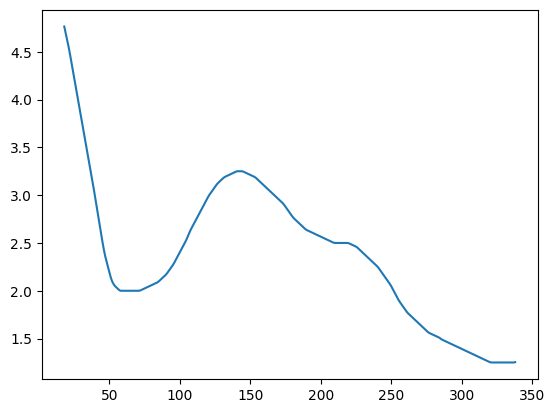

In [282]:
result2.trend.plot()

In [283]:
trend1 = result1.trend.dropna()
trend2 = result2.trend.dropna()

correlation= trend1.corr(trend2)

In [284]:
correlation

-0.7404451896116717

# 집값과 유가 시계열 분해

In [285]:
data

,transaction_date,exclusive_use_area,Value,Dubai,Brent,WTI,total_price_index,living_price_index,Fresh_Food_Index,transaction_real_price,diff_house
0,2008-01-05,71.319094,5.00,90.668571,95.535714,96.787143,0.5,0.5,-1.0,35815.171082,NaN
1,2008-01-15,70.938502,5.00,86.401667,90.450000,91.721667,0.5,0.5,-1.0,34882.781918,-932.389164
2,2008-01-25,71.455052,5.00,85.121111,90.074444,90.458750,0.5,0.5,-1.0,34834.696110,-48.085808
3,2008-02-05,72.265355,5.00,85.577500,89.493333,89.068333,0.4,0.3,1.3,35922.383598,1087.687488
4,2008-02-15,70.855270,5.00,89.928750,95.165000,95.907143,0.4,0.3,1.3,34485.933962,-1436.449636
...,...,...,...,...,...,...,...,...,...,...,...
352,2017-10-15,80.284361,1.25,55.442857,57.398750,51.487500,-0.1,-0.4,-8.4,66627.877070,6299.176855
353,2017-10-25,80.571541,1.25,56.741429,59.450000,53.088571,-0.1,-0.4,-8.4,67519.816520,891.939451
354,2017-11-05,82.509710,1.25,60.695000,62.760000,56.218750,-0.7,-0.8,-8.0,72752.877442,5233.060922
355,2017-11-15,81.441121,1.25,60.591667,62.256667,55.928333,-0.7,-0.8,-8.0,75141.608982,2388.731540


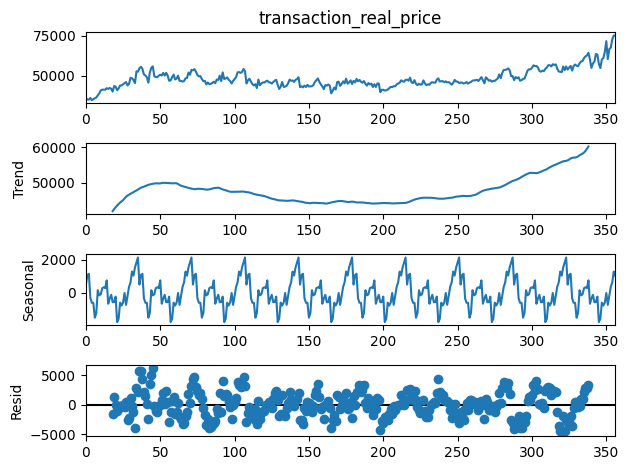

In [286]:
result_oil = seasonal_decompose(data.transaction_real_price, model='additive', 
                            period=36)
result_oil.plot()
plt.show()

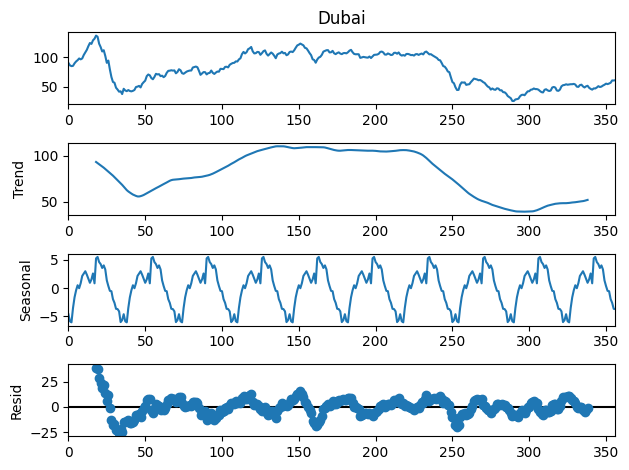

In [287]:
result_oil2 = seasonal_decompose(data.Dubai, model='additive', 
                            period=36)
result_oil2.plot()
plt.show()

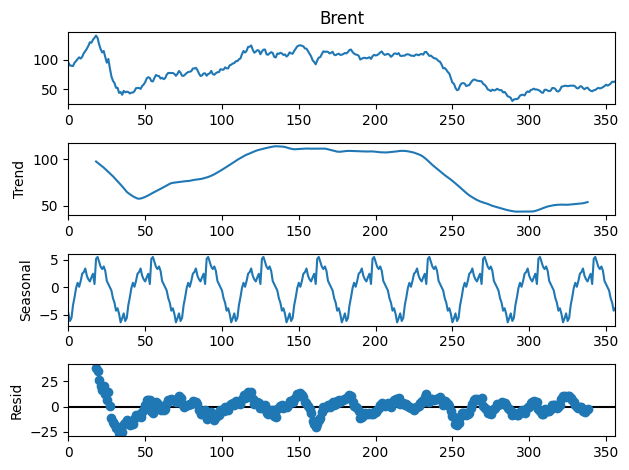

In [288]:
result_oil3 = seasonal_decompose(data.Brent, model='additive', 
                            period=36)
result_oil3.plot()
plt.show()

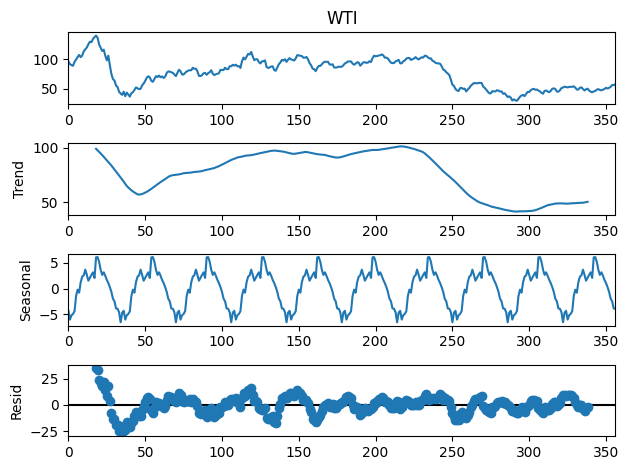

In [289]:
result_oil4 = seasonal_decompose(data.WTI, model='additive', 
                            period=36)
result_oil4.plot()
plt.show()

<AxesSubplot: >

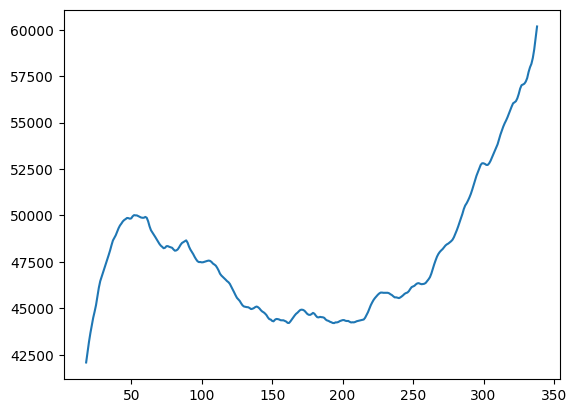

In [290]:
result_oil.trend.plot()

<AxesSubplot: >

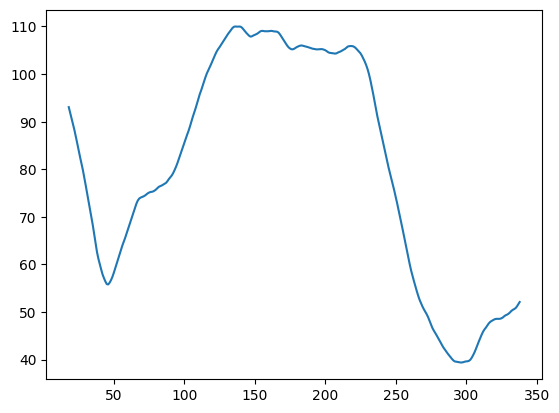

In [291]:
result_oil2.trend.plot()

In [292]:
trend_oil = result_oil.trend.dropna()
trend_oil2 = result_oil2.trend.dropna()
trend_oil3 = result_oil3.trend.dropna()
trend_oil4 = result_oil4.trend.dropna()

In [293]:
correlation1 = trend_oil.corr(trend_oil2)
correlation2 = trend_oil.corr(trend_oil3)
correlation3 = trend_oil.corr(trend_oil4)

In [294]:
correlation1, correlation2, correlation3

(-0.8174057524752502, -0.8187840776778038, -0.819299484593294)

# 물가

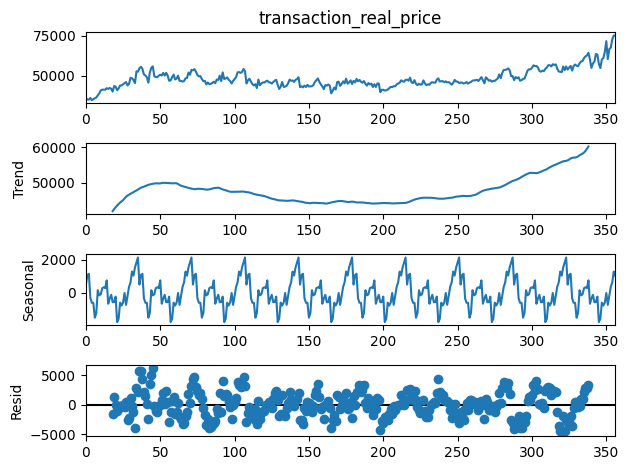

In [295]:
result_price0 = seasonal_decompose(data.transaction_real_price, model='additive', 
                            period=36)
result_price0.plot()
plt.show()

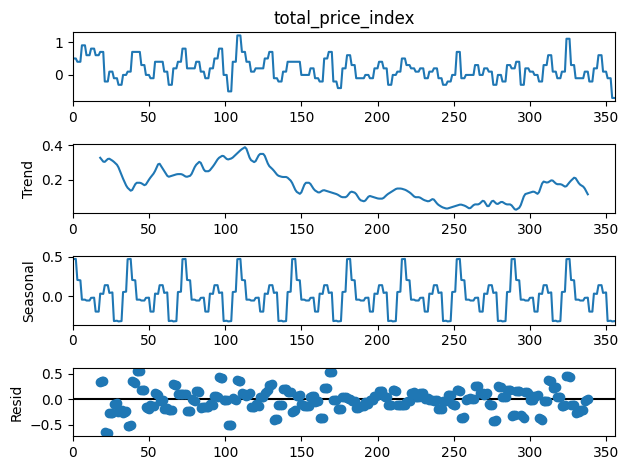

In [296]:
result_price1 = seasonal_decompose(data.total_price_index, model='additive', 
                            period=36)
result_price1.plot()
plt.show()

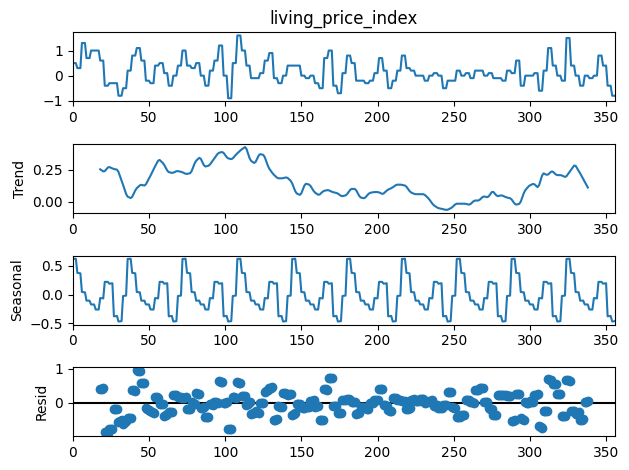

In [297]:
result_price2 = seasonal_decompose(data.living_price_index, model='additive', 
                            period=36)
result_price2.plot()
plt.show()

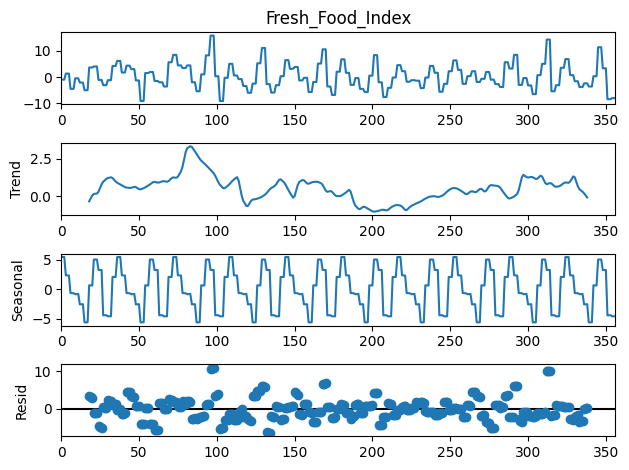

In [298]:
result_price3 = seasonal_decompose(data.Fresh_Food_Index, model='additive', 
                            period=36)
result_price3.plot()
plt.show()

In [299]:
trend_price0 = result_price0.trend.dropna()
trend_price1 = result_price2.trend.dropna()
correlation11= trend_price0.corr(trend_price1)

In [300]:
correlation11 

0.20690787671937716

In [301]:
trend_price2 = result_price2.trend.dropna()
trend_price3 = result_price3.trend.dropna()

correlation12= trend_price0.corr(trend_price2)
correlation13= trend_price0.corr(trend_price3)

In [302]:
correlation11, correlation12, correlation13

(0.20690787671937716, 0.20690787671937716, 0.3571333837539149)

# 추세 데이터 프레임 만들기

In [303]:
df = pd.concat([trend1, trend2, trend_oil2, trend_oil3, trend_oil4, trend_price1, trend_price2, trend_price3], axis=1, keys=['Transaction_real_price', 'Value', 'Dubai', 'Brent', 'WTI', 'Total_price_index', 'Living_price_index', 'Fresh_food_index'])
df = df.reset_index(drop=True)
df

,Transaction_real_price,Value,Dubai,Brent,WTI,Total_price_index,Living_price_index,Fresh_food_index
0,42084.046670,4.763889,93.059125,97.755557,99.014152,0.254167,0.254167,-0.351389
1,42630.920887,4.694444,91.850200,96.444668,97.535303,0.245833,0.245833,-0.154167
2,43186.819652,4.625000,90.662374,95.191637,96.123098,0.237500,0.237500,0.043056
3,43661.442035,4.555556,89.495915,93.958144,94.785668,0.240278,0.240278,0.147222
4,44082.838228,4.479167,88.266173,92.611986,93.278132,0.254167,0.254167,0.158333
...,...,...,...,...,...,...,...,...
316,58167.175389,1.250000,50.610929,52.395458,49.428330,0.200000,0.200000,0.375000
317,58483.565115,1.250000,50.806948,52.597705,49.493260,0.177778,0.177778,0.291667
318,58947.427746,1.250000,51.161001,52.951028,49.699389,0.155556,0.155556,0.181944
319,59543.948870,1.250000,51.646267,53.403575,50.007855,0.133333,0.133333,0.045833


# 다중공선성 확인

In [304]:
model0 = smf.ols('Transaction_real_price~ Value+Dubai+Brent+WTI+Total_price_index+Living_price_index+Fresh_food_index', data = df).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Transaction_real_price   R-squared:                       0.820
Model:                                OLS   Adj. R-squared:                  0.816
Method:                     Least Squares   F-statistic:                     237.9
Date:                    Sat, 16 Dec 2023   Prob (F-statistic):          1.37e-113
Time:                            22:20:08   Log-Likelihood:                -2811.3
No. Observations:                     321   AIC:                             5637.
Df Residuals:                         314   BIC:                             5663.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           6.004e+04    515.351    116.497      0.000     5.9e+04    6.11e+04
Value              -1187.6737    197.575     -6.011      0.000   -1576.411    -798.936
Dubai                394.1816    112.346      3.509      0.001     173.135     615.228
Brent               -354.4474    104.224     -3.401      0.001    -559.513    -149.381
WTI                 -171.8195     28.173     -6.099      0.000    -227.250    -116.389
Total_price_index   6182.6945    472.872     13.075      0.000    5252.296    7113.093
Living_price_index  6182.6945    472.872     13.075      0.000    5252.296    7113.093
Fresh_food_index    -588.8336    145.999     -4.033      0.000    -876.093    -301.574
==============================================================================
Omnibus:                       56.477   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.333
Skew:                           0.829   Prob(JB):                     2.76e-32
Kurtosis:                       5.849   Cond. No.                     2.63e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.6e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [306]:
model_house_price = smf.ols('Transaction_real_price~ Value+Dubai+Brent+WTI+Total_price_index+Living_price_index+Fresh_food_index', data = df).fit()
import patsy
y, X = patsy.dmatrices('Transaction_real_price~ Value+Dubai+Brent+WTI+Total_price_index+Living_price_index+Fresh_food_index', df, return_type='matrix')

from statsmodels.stats.outliers_influence import variance_inflation_factor
for i, x in enumerate(X.design_info.column_names):
    print( 'VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 35.19023068918039
VIF of Value : 2.8606961927847077
VIF of Dubai : 985.6419162641295
VIF of Brent : 873.5261000329181
VIF of WTI : 43.13936465506125
VIF of Total_price_index : inf
VIF of Living_price_index : inf
VIF of Fresh_food_index : 1.9263515174780763


C:\Users\A\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [307]:
#다중공선성 문제가 있어서 유가 데이터 중에서 WTI변수만, Total_price_index와 Living_price_index 중에 Total_price_index만 사용

In [313]:
cor_trend = df.corr()
cor_trend

,Transaction_real_price,Value,Dubai,Brent,WTI,Total_price_index,Living_price_index,Fresh_food_index
Transaction_real_price,1.000000,-0.740445,-0.817406,-0.818784,-0.819299,0.206908,0.206908,0.357133
Value,-0.740445,1.000000,0.734454,0.739801,0.766617,0.140274,0.140274,-0.178542
Dubai,-0.817406,0.734454,1.000000,0.999225,0.982979,0.058965,0.058965,-0.355935
Brent,-0.818784,0.739801,0.999225,1.000000,0.981393,0.061421,0.061421,-0.365580
WTI,-0.819299,0.766617,0.982979,0.981393,1.000000,0.126232,0.126232,-0.328003
Total_price_index,0.206908,0.140274,0.058965,0.061421,0.126232,1.000000,1.000000,0.460871
Living_price_index,0.206908,0.140274,0.058965,0.061421,0.126232,1.000000,1.000000,0.460871
Fresh_food_index,0.357133,-0.178542,-0.355935,-0.365580,-0.328003,0.460871,0.460871,1.000000


###  금리+WTI+총물가지수+식품물가

In [320]:
model1 = smf.ols('Transaction_real_price~ Value+WTI+Total_price_index+Fresh_food_index', data = df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Transaction_real_price   R-squared:                       0.813
Model:                                OLS   Adj. R-squared:                  0.810
Method:                     Least Squares   F-statistic:                     342.4
Date:                    Sat, 16 Dec 2023   Prob (F-statistic):          1.69e-113
Time:                            23:00:19   Log-Likelihood:                -2817.6
No. Observations:                     321   AIC:                             5645.
Df Residuals:                         316   BIC:                             5664.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.887e+04    387.049    152.091      0.000    5.81e+04    5.96e+04
Value             -1445.4231    186.237     -7.761      0.000   -1811.844   -1079.003
WTI                -119.4390      7.299    -16.365      0.000    -133.799    -105.079
Total_price_index  1.106e+04    863.647     12.811      0.000    9364.703    1.28e+04
Fresh_food_index   -379.2535    134.709     -2.815      0.005    -644.293    -114.214
==============================================================================
Omnibus:                       81.739   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.808
Skew:                           1.111   Prob(JB):                     2.32e-57
Kurtosis:                       6.816   Cond. No.                         776.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1]:
1.106e+04

11060.0

### VIF

In [312]:
model_house_price = smf.ols('Transaction_real_price~ Value+WTI+Total_price_index+Fresh_food_index', data = df).fit()
import patsy
y, X = patsy.dmatrices('Transaction_real_price~ Value+WTI+Total_price_index+Fresh_food_index', df, return_type='matrix')

from statsmodels.stats.outliers_influence import variance_inflation_factor
for i, x in enumerate(X.design_info.column_names):
    print( 'VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 19.21881280897471
VIF of Value : 2.461033514408339
VIF of WTI : 2.803290856300389
VIF of Total_price_index : 1.4258087496778118
VIF of Fresh_food_index : 1.587848423241739
